In [1]:
import pandas as pd
import torch
import numpy as np
import os
import re
from transformers import BertTokenizer, BertModel, BertForMaskedLM, pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import OneHotEncoder
from transformers import DataCollatorForLanguageModeling
import joblib
import pickle
from sklearn.metrics import silhouette_score
from torch import nn
from datasets import Dataset
from transformers import Trainer, TrainingArguments

# Set directories for saving models and loading datasets
model_dir = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7'
data_path = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Data/MINDlarge_train/Cleaned Datasets/News_cleaned.csv'
output_data_dir = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Data/MINDlarge_train/Cleaned Datasets'
output_data_path = os.path.join(output_data_dir, 'News_Features_Engineered_Dataset.parquet')
embedding_output_path = os.path.join(output_data_dir, 'news_embeddings_BERT_and_Kmeans.npy')

# Ensure model directory exists
os.makedirs(model_dir, exist_ok=True)

# Allowing for parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "true"

# Set the device to MPS if available, otherwise use CPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Helper function to standardize News ID format
def standardize_news_id(nid):
    """Standardize News ID by removing extra spaces."""
    return re.sub(r"\s+", "", nid) if isinstance(nid, str) else nid

# Load the dataset
print("Loading dataset...")
data = pd.read_csv(data_path)
print("Dataset loaded.")

# Standardize News ID
print("Standardizing News IDs...")
data['News ID'] = data['News ID'].apply(standardize_news_id)

# Combine text columns into a single representation for each article
print("Combining text columns...")
data["text"] = (
    data["Category"] + " " +
    data["Subcategory"] + " " +
    data["Title"] + " " +
    data["Abstract"]
)

# Fine-Tune BERT for MLM
def fine_tune_bert_for_mlm(data, model_dir):
    """
    Fine-tune BERT for Masked Language Modeling (MLM).
    Args:
        data (pd.DataFrame): Input data containing a "text" column.
        model_dir (str): Directory to save tokenizer and model.
    """
    print("Step 1: Fine-tuning BERT for Masked Language Modeling...")
    
    # Convert dataset to Hugging Face Dataset format
    print("Converting dataset...")
    dataset = Dataset.from_pandas(data[["text"]])

    # Load or train tokenizer
    tokenizer_path = os.path.join(model_dir, "bert_tokenizer")
    if os.path.exists(tokenizer_path):
        print("Loading existing BERT tokenizer...")
        tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    else:
        print("Training new BERT tokenizer...")
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        tokenizer.save_pretrained(tokenizer_path)
        print(f"BERT tokenizer trained and saved to {tokenizer_path}")

    # Tokenize dataset
    print("Tokenizing dataset...")
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
    tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
    print("Tokenization completed.")

    # Data collator for MLM
    print("Initializing data collator for MLM...")
    data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

    # Load or train model
    model_path = os.path.join(model_dir, "bert_mlm_model")
    if os.path.exists(model_path):
        print("Loading existing BERT model for Masked Language Modeling...")
        model = BertForMaskedLM.from_pretrained(model_path)
    else:
        print("Training new BERT model for Masked Language Modeling...")
        model = BertForMaskedLM.from_pretrained("bert-base-uncased")
        model.save_pretrained(model_path)
        print(f"BERT model trained and saved to {model_path}")

    # Training arguments
    print("Setting up training arguments...")
    training_args = TrainingArguments(
        output_dir=model_dir,
        eval_strategy="no",
        learning_rate=5e-5,
        per_device_train_batch_size=16,
        num_train_epochs=3,
        save_steps=10_000,
        save_total_limit=2,
        logging_dir="./logs",
        logging_steps=500
    )

    # Trainer
    print("Initializing Trainer...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer
    )

    # Train the model
    print("Starting training...")
    trainer.train()
    print("BERT fine-tuning completed successfully.")
    
fine_tune_bert_for_mlm(data, model_dir)

# Generate Embeddings
def generate_embeddings(data, model_dir, output_data_dir, device, output_dim=768):
    """
    Generate 768-dimensional embeddings for text using a fine-tuned BERT model.
    Args:
        data (pd.DataFrame): Input data containing a "text" column.
        model_dir (str): Directory containing the fine-tuned model.
        output_data_dir (str): Directory to save the generated embeddings.
        device (torch.device): Device to run the model on.
        output_dim (int): Dimension of the output embeddings.
    """
    print("Step 2: Generating embeddings...")
    
    # Load BERT model and tokenizer
    bert_model_path = os.path.join(model_dir, "bert_mlm_model")
    print(f"Loading BERT model from {bert_model_path}...")
    bert_model = BertModel.from_pretrained(bert_model_path).to(device)
    print("BERT model loaded successfully.")

    tokenizer_path = os.path.join(model_dir, "bert_tokenizer")
    print(f"Loading tokenizer from {tokenizer_path}...")
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
    print("Tokenizer loaded successfully.")

    # Batch processing for embedding generation
    def generate_embeddings_batch(texts, model, tokenizer, device, batch_size=32):
        model.eval()
        embeddings = []
        print("Generating embeddings in batches...")
        with torch.no_grad():
            for i in range(0, len(texts), batch_size):
                batch_texts = texts[i:i + batch_size]
                inputs = tokenizer(
                    batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512
                ).to(device)
                outputs = model(**inputs)
                embeddings.append(outputs.pooler_output.cpu().numpy())
                print(f"Processed batch {i // batch_size + 1} of {len(texts) // batch_size + 1}")
        return np.vstack(embeddings)

    print("Generating embeddings for the dataset...")
    embeddings = generate_embeddings_batch(data["text"].tolist(), bert_model, tokenizer, device)
    print("Embeddings generation completed.")

    # Save embeddings
    print("Saving embeddings...")
    data["BERT-Embeddings"] = embeddings.tolist()
    np.save(os.path.join(output_data_dir, "news_embeddings.npy"), embeddings)
    data[["News ID", "BERT-Embeddings"]].to_parquet(os.path.join(output_data_dir, "news_BERT_Only_embeddings.parquet"), index=False)
    print(f"Embeddings saved to {output_data_dir} successfully.")

generate_embeddings(data, model_dir, output_data_dir, device, output_dim=768)

# Step 3: Sentiment and Emotion Analysis
sentiment_model_dir = os.path.join(model_dir, "sentiment_model")
if not os.path.exists(sentiment_model_dir):
    print("Training and saving sentiment model...")
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="distilbert/distilbert-base-uncased-finetuned-sst-2-english",
        revision="714eb0f",
        device=0 if torch.backends.mps.is_available() else -1
    )
    sentiment_pipeline.model.save_pretrained(sentiment_model_dir)
    sentiment_pipeline.tokenizer.save_pretrained(sentiment_model_dir)
    print("Sentiment model trained and saved.")
else:
    print("Loading existing sentiment model...")
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=sentiment_model_dir,
        device=0 if torch.backends.mps.is_available() else -1
    )

data['Sentiment'] = data.apply(
    lambda row: sentiment_pipeline(row['Title'][:512] + " " + row['Abstract'][:512])[0]['label'], axis=1
)

emotion_model_dir = os.path.join(model_dir, "emotion_model")
if not os.path.exists(emotion_model_dir):
    print("Training and saving emotion model...")
    emotion_pipeline = pipeline(
        "text-classification",
        model="bhadresh-savani/distilbert-base-uncased-emotion",
        device=0 if torch.backends.mps.is_available() else -1
    )
    emotion_pipeline.model.save_pretrained(emotion_model_dir)
    emotion_pipeline.tokenizer.save_pretrained(emotion_model_dir)
    print("Emotion model trained and saved.")
else:
    print("Loading existing emotion model...")
    emotion_pipeline = pipeline(
        "text-classification",
        model=emotion_model_dir,
        device=0 if torch.backends.mps.is_available() else -1
    )

data['Emotion'] = data.apply(
    lambda row: emotion_pipeline(row['Title'][:512] + " " + row['Abstract'][:512])[0]['label'], axis=1
)

# Step 4: One-Hot Encoding and K-means Clustering
encoder_path = os.path.join(model_dir, 'one_hot_encoder.pkl')

# Combine features as they are
combined_features = np.column_stack((
    data['Category'].astype(str), 
    data['Subcategory'].astype(str), 
    data['Sentiment'].astype(str), 
    data['Emotion'].astype(str)
))

# Train or load the one-hot encoder
if os.path.exists(encoder_path):
    print("Loading existing OneHotEncoder...")
    encoder = joblib.load(encoder_path)
else:
    print("Training new OneHotEncoder...")
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(combined_features)
    joblib.dump(encoder, encoder_path)
    print(f"OneHotEncoder trained and saved to {encoder_path}")

# Apply one-hot encoding
print("Applying one-hot encoding to features...")
one_hot_encoded_features = encoder.transform(combined_features)

# Proceed with K-means clustering
kmeans_path = os.path.join(model_dir, 'kmeans_model.pkl')
if os.path.exists(kmeans_path):
    print("Loading existing K-means model...")
    kmeans = joblib.load(kmeans_path)
else:
    print("Training K-means model...")
    max_k = 100
    best_k = 2
    best_score = -1
    for k in range(2, max_k + 1):
        kmeans_candidate = MiniBatchKMeans(n_clusters=k, batch_size=1000, random_state=0)
        cluster_labels = kmeans_candidate.fit_predict(one_hot_encoded_features)
        score = silhouette_score(one_hot_encoded_features, cluster_labels)
        if score > best_score:
            best_k = k
            best_score = score
    kmeans = MiniBatchKMeans(n_clusters=best_k, batch_size=1000, random_state=0)
    kmeans.fit(one_hot_encoded_features)
    joblib.dump(kmeans, kmeans_path)
    print("K-means model trained and saved.")

# Assign clusters to data
data['K-means Clusters'] = kmeans.predict(one_hot_encoded_features)
centroids = kmeans.cluster_centers_

# Add K-means embeddings to data
data['K-means Embeddings'] = data['K-means Clusters'].apply(lambda x: centroids[x].tolist())

# Save metadata
metadata = {
    "optimal_k": best_k,
    "features": ["Category", "Subcategory", "Sentiment", "Emotion"]
}
with open(os.path.join(model_dir, "metadata.pkl"), "wb") as f:
    pickle.dump(metadata, f)
    print("Metadata saved.")

# Save final data and embeddings
data[['News ID', 'BERT-Embeddings', 'Sentiment', 'Emotion', 'K-means Clusters', 'K-means Embeddings']].to_parquet(output_data_path, index=False)
news_embeddings = {
    "News ID": data['News ID'].tolist(),
    "BERT-Embeddings": np.array(data['BERT-Embeddings'].tolist()),
    "K-means Embeddings": np.array(data['K-means Embeddings'].tolist())
}
np.save(embedding_output_path, news_embeddings)

print(f"Data and embeddings saved to {output_data_dir}")

Loading dataset...
Dataset loaded.
Standardizing News IDs...
Combining text columns...
Step 1: Fine-tuning BERT for Masked Language Modeling...
Converting dataset...
Training new BERT tokenizer...
BERT tokenizer trained and saved to /Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/bert_tokenizer
Tokenizing dataset...


Map:   0%|          | 0/96106 [00:00<?, ? examples/s]

Tokenization completed.
Initializing data collator for MLM...
Training new BERT model for Masked Language Modeling...


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

BERT model trained and saved to /Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/bert_mlm_model
Setting up training arguments...
Initializing Trainer...
Starting training...


/var/folders/cn/p9c8lph95t14chk7vtpcpzm00000gn/T/ipykernel_49233/1090078311.py:119: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Some weights of BertModel were not initialized from the model checkpoint at /Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/bert_mlm_model and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT fine-tuning completed successfully.
Step 2: Generating embeddings...
Loading BERT model from /Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/bert_mlm_model...
BERT model loaded successfully.
Loading tokenizer from /Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/bert_tokenizer...
Tokenizer loaded successfully.
Generating embeddings for the dataset...
Generating embeddings in batches...
Processed batch 1 of 3004
Processed batch 2 of 3004
Processed batch 3 of 3004
Processed batch 4 of 3004
Processed batch 5 of 3004
Processed batch 6 of 3004
Processed batch 7 of 3004
Processed batch 8 of 3004
Processed batch 9 of 3004
Processed batch 10 of 3004
Processed batch 11 of 3004
Processed batch 12 of 3004
Processed batch 13 of 3004
Processed batch 14 of 3004
Processed batch 15 of 3004
Processed batch 16 of 3004
Processed batch 17 of 3004
Process

In [2]:
import pandas as pd
import re

# Load the behavior dataset
behavior_data_path = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Data/MINDlarge_train/Cleaned Datasets/cleaned_behavior_dataset.csv'
behavior_data = pd.read_csv(behavior_data_path)

# Columns to retain
columns_to_keep = ['User ID', 'Displayed News List', 'Clicked News IDs', 'Not-Clicked News IDs']

# Drop all columns except the ones specified
behavior_data = behavior_data[columns_to_keep]

# Check and display the data types of each column before processing
print("Data types before conversion:\n", behavior_data.dtypes)

# Function to convert to comma-separated and handle concatenated news IDs
def convert_to_comma_separated(value):
    if pd.isna(value):
        return ""  # Handle NaN values
    # Remove brackets, quotes, spaces, and any unwanted characters
    value = re.sub(r"[\[\]'\" ]", "", value)
    # Add comma between concatenated IDs using regex to find patterns like 'N[digits]N[digits]'
    value = re.sub(r"(N\d+)(?=N\d+)", r"\1,", value)
    return value

# Apply conversion to 'Displayed News List', 'Clicked News IDs', and 'Not-Clicked News IDs'
behavior_data['Displayed News List'] = behavior_data['Displayed News List'].apply(convert_to_comma_separated)
behavior_data['Clicked News IDs'] = behavior_data['Clicked News IDs'].apply(convert_to_comma_separated)
behavior_data['Not-Clicked News IDs'] = behavior_data['Not-Clicked News IDs'].apply(convert_to_comma_separated)

# Validation function to confirm no concatenated IDs remain
def check_concatenated_ids(column):
    pattern = r"N\d+N\d+"  # Pattern to detect concatenated IDs
    concatenated_ids = behavior_data[column].str.contains(pattern, regex=True).sum()
    return concatenated_ids == 0

# Check for concatenated IDs in all relevant columns
columns_to_check = ['Displayed News List', 'Clicked News IDs', 'Not-Clicked News IDs']
for col in columns_to_check:
    if check_concatenated_ids(col):
        print(f"No concatenated IDs found in '{col}'.")
    else:
        print(f"Concatenated IDs detected in '{col}' after processing.")

# Ensure 'Clicked News IDs' and 'Not-Clicked News IDs' have the same data type as 'Displayed News List'
displayed_news_type = behavior_data['Displayed News List'].dtype
behavior_data['Clicked News IDs'] = behavior_data['Clicked News IDs'].astype(displayed_news_type)
behavior_data['Not-Clicked News IDs'] = behavior_data['Not-Clicked News IDs'].astype(displayed_news_type)

# Check and display the data types after conversion to confirm changes
print("Data types after conversion:\n", behavior_data.dtypes)

# Display the first few rows to confirm the dataset structure
print("Processed Behavior Dataset:\n", behavior_data.head(10))

# Save the processed dataset if needed
output_behavior_data_path = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Data/MINDlarge_train/Cleaned Datasets/processed_behavior_dataset.csv'
behavior_data.to_csv(output_behavior_data_path, index=False)

Data types before conversion:
 User ID                 object
Displayed News List     object
Clicked News IDs        object
Not-Clicked News IDs    object
dtype: object
No concatenated IDs found in 'Displayed News List'.
No concatenated IDs found in 'Clicked News IDs'.
No concatenated IDs found in 'Not-Clicked News IDs'.
Data types after conversion:
 User ID                 object
Displayed News List     object
Clicked News IDs        object
Not-Clicked News IDs    object
dtype: object
Processed Behavior Dataset:
    User ID                                Displayed News List  \
0   U87243  N8668,N39081,N65259,N79529,N73408,N43615,N2937...   
1  U598644  N56056,N8726,N70353,N67998,N83823,N111108,N107...   
2  U532401  N128643,N87446,N122948,N9375,N82348,N129412,N5...   
3  U593596  N31043,N39592,N4104,N8223,N114581,N92747,N1207...   
4  U239687  N65250,N122359,N71723,N53796,N41663,N41484,N11...   
5  U521853  N8668,N29136,N128643,N9740,N9375,N52911,N12090...   
6  U687515               

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import pickle
import umap
import time
from ast import literal_eval
from collections import defaultdict
import re

# Directory paths
model_dir = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7'
data_path = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Data/MINDlarge_train/Cleaned Datasets/News_Features_Engineered_Dataset.parquet'
behavior_data_path = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Data/MINDlarge_train/Cleaned Datasets/processed_behavior_dataset.csv'
user_profiles_path = os.path.join(model_dir, 'user_profiles.pkl')
os.makedirs(model_dir, exist_ok=True)

# Device setup
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Using device: {device}")

# Helper function to standardize News ID format
def standardize_news_id(nid):
    """Standardize News ID by removing extra spaces."""
    return re.sub(r"\s+", "", nid) if isinstance(nid, str) else nid

# Helper function to standardize User ID format
def standardize_user_id(uid):
    """Standardize User ID by removing extra spaces and applying a consistent format."""
    return re.sub(r"\s+", "", str(uid)) if isinstance(uid, (str, int)) else uid

# Step 0: Load news embeddings
print("Step 0: Loading news embeddings.")

def load_parquet_embeddings_with_error_checking(data_path):
    """
    Load embeddings from a Parquet file, validate them, and count any errors during processing.

    Args:
        data_path (str): Path to the Parquet file containing saved embeddings.

    Returns:
        pd.DataFrame: DataFrame containing News ID, BERT-Embeddings, and K-means Embeddings.
    """
    # Initialize error count
    error_count = 0

    # Load the Parquet file
    try:
        embeddings_df = pd.read_parquet(data_path)
    except FileNotFoundError:
        raise FileNotFoundError(f"The file {data_path} does not exist.")
    except Exception as e:
        raise RuntimeError(f"Failed to load Parquet file: {e}")

    # Check for required columns
    required_columns = ["News ID", "BERT-Embeddings", "K-means Embeddings"]
    for column in required_columns:
        if column not in embeddings_df.columns:
            raise KeyError(f"Missing expected column in the Parquet file: {column}")

    # Helper function to validate and convert embeddings to float32
    def validate_and_convert_embedding(embedding, expected_size):
        nonlocal error_count
        try:
            array = np.array(embedding, dtype=np.float32)  # Convert to float32
            if array.size != expected_size:
                raise ValueError(f"Unexpected size: {array.size}")
            return array
        except (ValueError, TypeError):
            error_count += 1
            return np.zeros(expected_size, dtype=np.float32)  # Default to zero array on error

    # Expected sizes
    bert_embeddings = embeddings_df["BERT-Embeddings"].iloc[0]
    kmeans_embeddings = embeddings_df["K-means Embeddings"].iloc[0]
    bert_size = len(bert_embeddings) if isinstance(bert_embeddings, (list, np.ndarray)) else 768
    kmeans_size = len(kmeans_embeddings) if isinstance(kmeans_embeddings, (list, np.ndarray)) else 304

    # Validate embeddings and convert to float32
    embeddings_df["BERT-Embeddings"] = embeddings_df["BERT-Embeddings"].apply(lambda x: validate_and_convert_embedding(x, bert_size))
    embeddings_df["K-means Embeddings"] = embeddings_df["K-means Embeddings"].apply(lambda x: validate_and_convert_embedding(x, kmeans_size))

    # Print the error count
    print(f"Number of errors encountered during embedding validation: {error_count}")
    return embeddings_df

# Load the embeddings
data = load_parquet_embeddings_with_error_checking(data_path)

# Standardize News IDs
data['News ID'] = data['News ID'].apply(standardize_news_id)

# Inspect the DataFrame
print(data.head())

# Concatenate BERT-Embeddings (768 dimensions) and K-means Embeddings (304 dimensions)
bert_embedding_size = len(data['BERT-Embeddings'].iloc[0])  # Infer size from the first embedding
kmeans_embedding_size = len(data['K-means Embeddings'].iloc[0])  # Infer size from the first embedding

# Validate embedding dimensions before concatenation
print(f"BERT Embedding Size: {bert_embedding_size}")
print(f"K-means Embedding Size: {kmeans_embedding_size}")

# Ensure all embeddings are of expected dimensions
assert all(len(embedding) == bert_embedding_size for embedding in data['BERT-Embeddings']), \
    "Inconsistent BERT embedding size detected."
assert all(len(embedding) == kmeans_embedding_size for embedding in data['K-means Embeddings']), \
    "Inconsistent K-means embedding size detected."

def pad_embeddings(matrix, target_size=1088):
    """
    Pad the concatenated embeddings matrix to a fixed size along the second dimension.
    Adds zero-padding to the end of each row if the size is less than the target size (default: 1088).

    Parameters:
    - matrix (np.ndarray): Input concatenated embeddings matrix.
    - target_size (int, optional): Desired size along the second dimension (default: 1088).

    Returns:
    - np.ndarray: Padded matrix with dimensions [matrix.shape[0], target_size].
    """
    current_size = matrix.shape[1]
    if current_size < target_size:
        # Calculate the padding size
        padding_size = target_size - current_size
        # Apply zero-padding along the second dimension
        padded_matrix = np.pad(matrix, ((0, 0), (0, padding_size)), mode='constant', constant_values=0)
        print(f"Padded embeddings from size {current_size} to {target_size}.")
    else:
        padded_matrix = matrix  # No padding needed if already at or above target size
        print(f"No padding applied. Embeddings already of size {current_size}.")
    return padded_matrix

# Step 1: Concatenate embeddings
embedding_matrix = np.hstack([
    np.vstack(data['BERT-Embeddings'].values),  # Convert BERT-Embeddings to matrix form
    np.vstack(data['K-means Embeddings'].values)  # Convert K-means Embeddings to matrix form
])

# Step 2: Pad concatenated embeddings to a fixed size (e.g., 1088 dimensions)
target_size = 1088
padded_embedding_matrix = pad_embeddings(embedding_matrix, target_size)

# Step 3: Convert to tensors
embedding_tensor = torch.tensor(padded_embedding_matrix, dtype=torch.float32)

# Step 4: Add the tensor embeddings to the dataset
data['combined_embedding'] = [embedding_tensor[i] for i in range(embedding_tensor.size(0))]

# Step 5: Create news embeddings map
news_embeddings_map = {row['News ID']: row['combined_embedding'] for _, row in data.iterrows()}

# Print information for verification
print(f"Shape of concatenated embeddings: {embedding_matrix.shape}")
print(f"Shape of padded embeddings: {padded_embedding_matrix.shape}")
print(f"Sample news embeddings map: {list(news_embeddings_map.items())[:5]}")


# Step 6: Generate and Save/Load User Profiles
print("Step 6: Checking for existing user profiles.")
if os.path.exists(user_profiles_path):
    print("Loading user profiles from saved file.")
    with open(user_profiles_path, 'rb') as f:
        user_profiles = pickle.load(f)
else:
    print("Generating new user profiles.")
    behavior_df = pd.read_csv(behavior_data_path, usecols=['User ID', 'Displayed News List', 'Clicked News IDs', 'Not-Clicked News IDs'])

    # Standardize User IDs
    behavior_df['User ID'] = behavior_df['User ID'].apply(standardize_user_id)
    behavior_df['Clicked News IDs'] = behavior_df['Clicked News IDs'].apply(
        lambda x: [standardize_news_id(nid) for nid in x.split(',')] if isinstance(x, str) else []
    )
    behavior_df['Not-Clicked News IDs'] = behavior_df['Not-Clicked News IDs'].apply(
        lambda x: [standardize_news_id(nid) for nid in x.split(',')] if isinstance(x, str) else []
    )

    user_clicks = defaultdict(lambda: {'clicked': [], 'not_clicked': []})
    for _, row in behavior_df.iterrows():
        user_id = row['User ID']
        user_clicks[user_id]['clicked'].extend(row['Clicked News IDs'])
        user_clicks[user_id]['not_clicked'].extend(row['Not-Clicked News IDs'])

    user_profiles = {}
    for user_id, interactions in user_clicks.items():
        # Gather embeddings for clicked and not-clicked news
        clicked_embeddings = [torch.tensor(news_embeddings_map[cid], dtype=torch.float32).clone().detach()
                              for cid in interactions['clicked'] if cid in news_embeddings_map
        ]
        not_clicked_embeddings = [torch.tensor(news_embeddings_map[ncid], dtype=torch.float32).clone().detach()
                                  for ncid in interactions['not_clicked'] if ncid in news_embeddings_map
        ]

        # Compute preference and non-preference profiles
        if clicked_embeddings:
            preference_profile = torch.stack(clicked_embeddings).mean(dim=0)
        else:
            preference_profile = torch.zeros(1088, dtype=torch.float32)  # Zero tensor if no clicked embeddings

        if not_clicked_embeddings:
            non_preference_profile = torch.stack(not_clicked_embeddings).mean(dim=0)
        else:
            non_preference_profile = torch.zeros(1088, dtype=torch.float32)  # Zero tensor if no not-clicked embeddings

        user_profiles[user_id] = {
            'preference_profile': preference_profile,
            'non_preference_profile': non_preference_profile
        }

    # Save the updated user profiles as tensors
    with open(user_profiles_path, 'wb') as f:
        pickle.dump(user_profiles, f)
    print(f"User profiles saved to {user_profiles_path}.")

Using device: mps
Step 0: Loading news embeddings.
Number of errors encountered during embedding validation: 0
  News ID                                    BERT-Embeddings Sentiment  \
0  N88753  [0.098979056, -0.57353175, -0.41958198, -0.099...  POSITIVE   
1  N45436  [-0.1314764, -0.6061604, -0.36188546, 0.075442...  POSITIVE   
2  N23144  [-0.30497104, -0.47108555, -0.30182517, -0.334...  NEGATIVE   
3  N93187  [-0.29341298, -0.55180466, -0.36336127, -0.261...  NEGATIVE   
4  N75236  [-0.23288968, -0.63734144, -0.24492687, 0.1808...  NEGATIVE   

   Emotion  K-means Clusters  \
0    anger                10   
1    anger                10   
2      joy                66   
3     fear                37   
4  sadness                72   

                                  K-means Embeddings  
0  [0.05628373, 0.00539707, 0.07555898, 0.0485736...  
1  [0.05628373, 0.00539707, 0.07555898, 0.0485736...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.

/var/folders/cn/p9c8lph95t14chk7vtpcpzm00000gn/T/ipykernel_84853/520482010.py:195: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clicked_embeddings = [torch.tensor(news_embeddings_map[cid], dtype=torch.float32).clone().detach()
/var/folders/cn/p9c8lph95t14chk7vtpcpzm00000gn/T/ipykernel_84853/520482010.py:198: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  not_clicked_embeddings = [torch.tensor(news_embeddings_map[ncid], dtype=torch.float32).clone().detach()


User profiles saved to /Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/user_profiles.pkl.


In [2]:
# File path
file_path = '/Users/n7/Desktop/ie University SAMBD Acadamics/Capstone Project Revised/Machine Learning models/Trained Models/Version7.7/user_profiles.pkl'

# Load user profiles from the pickle file
try:
    with open(file_path, 'rb') as f:
        user_profiles = pickle.load(f)
    print("User profiles successfully loaded.")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    exit()
except Exception as e:
    print(f"Error loading user profiles: {e}")
    exit()

# Initialize lists to store similarity metrics
cosine_similarities = []
mean_differences = []
max_differences = []
user_ids = []

# Iterate through user profiles and compute metrics
for user_id, profiles in user_profiles.items():
    try:
        preference_profile = torch.tensor(profiles['preference_profile'])
        non_preference_profile = torch.tensor(profiles['non_preference_profile'])

        # Compute cosine similarity
        cos_sim = torch.nn.functional.cosine_similarity(preference_profile, non_preference_profile, dim=0).item()
        cosine_similarities.append(cos_sim)

        # Compute element-wise differences
        diff = torch.abs(preference_profile - non_preference_profile)
        mean_diff = diff.mean().item()
        max_diff = diff.max().item()

        mean_differences.append(mean_diff)
        max_differences.append(max_diff)
        user_ids.append(user_id)
    except Exception as e:
        print(f"Error processing user_id {user_id}: {e}")

# Convert metrics to a DataFrame for analysis
similarity_df = pd.DataFrame({
    'User ID': user_ids,
    'Cosine Similarity': cosine_similarities,
    'Mean Difference': mean_differences,
    'Max Difference': max_differences
})

# Print summary statistics
print("Summary of Similarity Metrics:")
print(similarity_df.describe())

# Analyze if the profiles are distinct enough
print("\nDistinctiveness Analysis:")
print(f"Average Cosine Similarity: {similarity_df['Cosine Similarity'].mean():.4f}")
print(f"Average Mean Difference: {similarity_df['Mean Difference'].mean():.4f}")
print(f"Average Max Difference: {similarity_df['Max Difference'].mean():.4f}")

User profiles successfully loaded.


/var/folders/cn/p9c8lph95t14chk7vtpcpzm00000gn/T/ipykernel_84853/2216914833.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preference_profile = torch.tensor(profiles['preference_profile'])
/var/folders/cn/p9c8lph95t14chk7vtpcpzm00000gn/T/ipykernel_84853/2216914833.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  non_preference_profile = torch.tensor(profiles['non_preference_profile'])


Summary of Similarity Metrics:
       Cosine Similarity  Mean Difference  Max Difference
count      698365.000000    698365.000000   698365.000000
mean            0.897295         0.059243        0.556257
std             0.128583         0.026570        0.273871
min             0.000000         0.000000        0.000000
25%             0.871006         0.039142        0.327153
50%             0.929867         0.053935        0.485106
75%             0.961640         0.076274        0.836717
max             1.000000         0.192086        1.059827

Distinctiveness Analysis:
Average Cosine Similarity: 0.8973
Average Mean Difference: 0.0592
Average Max Difference: 0.5563


In [3]:
from torch.nn.functional import cosine_similarity

# Function to compute cosine similarity for clicked and not-clicked news against user profiles
def compute_cosine_similarity_detailed(user_profiles, news_embeddings_map, user_clicks, num_users=10):
    """
    Compute cosine similarity between user profiles and news embeddings for clicked and not-clicked news.

    Args:
        user_profiles (dict): User profiles with preference and non-preference profiles.
        news_embeddings_map (dict): Map of News IDs to their combined embeddings.
        user_clicks (dict): Dictionary of user interactions with clicked and not-clicked news.
        num_users (int): Number of users to compute similarity for.

    Returns:
        dict: A dictionary containing detailed cosine similarity results.
    """
    results = {}
    for user_idx, (user_id, interactions) in enumerate(user_clicks.items()):
        if user_idx >= num_users:
            break
        
        # Retrieve user profiles
        preference_profile = user_profiles[user_id]['preference_profile']
        non_preference_profile = user_profiles[user_id]['non_preference_profile']

        # Initialize lists to store similarities and corresponding news IDs
        clicked_similarities = []
        not_clicked_similarities = []

        # Compute cosine similarity for clicked news
        for news_id in interactions['clicked']:
            if news_id in news_embeddings_map:
                news_embedding = news_embeddings_map[news_id]
                clicked_similarity = {
                    'News ID': news_id,
                    'Preference Similarity': cosine_similarity(preference_profile.unsqueeze(0), news_embedding.unsqueeze(0)).item(),
                    'Non-Preference Similarity': cosine_similarity(non_preference_profile.unsqueeze(0), news_embedding.unsqueeze(0)).item()
                }
                clicked_similarities.append(clicked_similarity)

        # Compute cosine similarity for not-clicked news
        for news_id in interactions['not_clicked']:
            if news_id in news_embeddings_map:
                news_embedding = news_embeddings_map[news_id]
                not_clicked_similarity = {
                    'News ID': news_id,
                    'Preference Similarity': cosine_similarity(preference_profile.unsqueeze(0), news_embedding.unsqueeze(0)).item(),
                    'Non-Preference Similarity': cosine_similarity(non_preference_profile.unsqueeze(0), news_embedding.unsqueeze(0)).item()
                }
                not_clicked_similarities.append(not_clicked_similarity)

        # Store results for the user
        results[user_id] = {
            'clicked_news': clicked_similarities,
            'not_clicked_news': not_clicked_similarities
        }

    return results


# Compute cosine similarity for the first 10 users
cosine_similarity_results = compute_cosine_similarity_detailed(user_profiles, news_embeddings_map, user_clicks, num_users=10)

# Display detailed results for the first 10 users
for user_id, similarities in cosine_similarity_results.items():
    print(f"User ID: {user_id}")
    print("  Clicked News Similarities:")
    for entry in similarities['clicked_news']:
        print(f"    News ID: {entry['News ID']}, Preference Similarity: {entry['Preference Similarity']:.4f}, Non-Preference Similarity: {entry['Non-Preference Similarity']:.4f}")
    print("  Not-Clicked News Similarities:")
    for entry in similarities['not_clicked_news']:
        print(f"    News ID: {entry['News ID']}, Preference Similarity: {entry['Preference Similarity']:.4f}, Non-Preference Similarity: {entry['Non-Preference Similarity']:.4f}")

User ID: U87243
  Clicked News Similarities:
    News ID: N94157, Preference Similarity: 0.8174, Non-Preference Similarity: 0.8059
    News ID: N78699, Preference Similarity: 0.8520, Non-Preference Similarity: 0.8336
    News ID: N71090, Preference Similarity: 0.8555, Non-Preference Similarity: 0.8467
    News ID: N31174, Preference Similarity: 0.8301, Non-Preference Similarity: 0.7933
    News ID: N26404, Preference Similarity: 0.7857, Non-Preference Similarity: 0.7512
    News ID: N43186, Preference Similarity: 0.8715, Non-Preference Similarity: 0.8248
    News ID: N80019, Preference Similarity: 0.8680, Non-Preference Similarity: 0.8379
    News ID: N99362, Preference Similarity: 0.8363, Non-Preference Similarity: 0.7810
    News ID: N116064, Preference Similarity: 0.8740, Non-Preference Similarity: 0.9010
  Not-Clicked News Similarities:
    News ID: N78206, Preference Similarity: 0.8496, Non-Preference Similarity: 0.8679
    News ID: N26368, Preference Similarity: 0.8471, Non-Prefe

Initializing model, optimizer, and scheduler.
MultiHeadAttentionModel(
  (multihead_attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1088, out_features=1088, bias=True)
  )
  (linear1): Linear(in_features=1088, out_features=1088, bias=True)
  (linear2): Linear(in_features=1088, out_features=544, bias=True)
  (linear3): Linear(in_features=544, out_features=272, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (output_layer): Linear(in_features=272, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Starting Training Loop with Validation Loss Monitoring.

Epoch 1/30
Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed

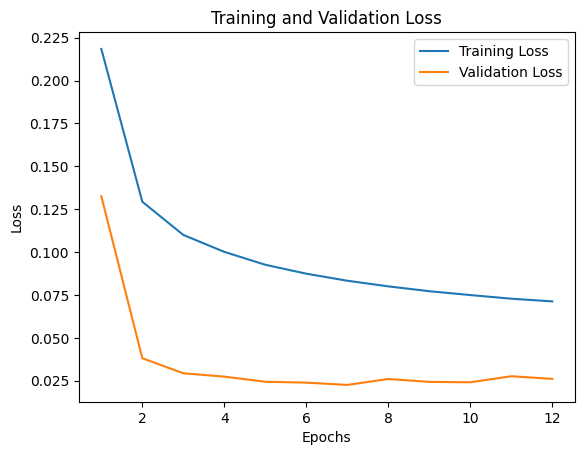

In [5]:
# Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 256
NUM_HEADS = 32  # Reduce to simplify the model
HIDDEN_DIM = 1088  # Reduce to avoid overfitting
LEARNING_RATE = 7e-5  # Lower the learning rate
EARLY_STOP_TRIGGER = 5  # Stop earlier if validation loss doesn’t improve
EMBED_DIM = 1088  # Match hidden dimension
DROPOUT_RATE = 0.5  # Increase dropout for regularization

# Step 3: Define the model
class MultiHeadAttentionModel(nn.Module):
    def __init__(self, embed_dim, num_heads, hidden_dim, dropout_rate):
        """
        Multi-head attention model with feed-forward layers and dropout.

        Args:
            embed_dim (int): Dimension of input embeddings.
            num_heads (int): Number of attention heads.
            hidden_dim (int): Dimension of hidden layers in the feed-forward network.
            dropout_rate (float): Dropout rate for regularization.
        """
        super(MultiHeadAttentionModel, self).__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.linear1 = nn.Linear(embed_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.linear3 = nn.Linear(hidden_dim // 2, hidden_dim // 4)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer
        self.output_layer = nn.Linear(hidden_dim // 4, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_news_pairs):
        """
        Forward pass for the model.

        Args:
            user_news_pairs (Tensor): Input tensor of shape (batch_size, 2, embed_dim).
        
        Returns:
            Tensor: Predicted scores for the input pairs.
        """
        # Multi-head attention
        attn_output, _ = self.multihead_attention(user_news_pairs, user_news_pairs, user_news_pairs)
        attn_output = attn_output.mean(dim=1)
        
        # Fully connected layers with dropout and activation
        x = self.dropout(self.relu(self.linear1(attn_output)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))
        
        # Output layer
        return self.sigmoid(self.output_layer(x))


# Initialize model, optimizer, and scheduler with updated hyperparameters
print("Initializing model, optimizer, and scheduler.")
model = MultiHeadAttentionModel(embed_dim=EMBED_DIM, num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout_rate=DROPOUT_RATE).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=EARLY_STOP_TRIGGER, verbose=True)  # Learning rate scheduler

# Print model structure to verify
print(model)

# Split user profiles into training and validation sets
train_user_ids, val_user_ids = train_test_split(list(user_profiles.keys()), test_size=0.1, random_state=42)
train_user_profiles = {uid: user_profiles[uid] for uid in train_user_ids}
val_user_profiles = {uid: user_profiles[uid] for uid in val_user_ids}

# Training loop with validation loss per epoch
print("Starting Training Loop with Validation Loss Monitoring.")
best_loss = float('inf')
trigger_count = 0
train_losses = []
validation_losses = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch + 1}/{NUM_EPOCHS}")
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    start_time = time.time()

    batch_inputs, batch_labels = [], []

    # Training phase
    for i, (user_id, profiles) in enumerate(train_user_profiles.items(), 1):
        # Get user preference and non-preference profile embeddings
        preference_profile = profiles['preference_profile'].to(device)
        non_preference_profile = profiles['non_preference_profile'].to(device)

        # Get clicked and not-clicked news IDs
        clicked_news_ids = user_clicks[user_id]['clicked']
        not_clicked_news_ids = user_clicks[user_id]['not_clicked']

        # Apply under-sampling
        if len(clicked_news_ids) > len(not_clicked_news_ids):
            clicked_news_ids = np.random.choice(clicked_news_ids, size=len(not_clicked_news_ids), replace=False)
        elif len(not_clicked_news_ids) > len(clicked_news_ids):
            not_clicked_news_ids = np.random.choice(not_clicked_news_ids, size=len(clicked_news_ids), replace=False)

        # Create input pairs for clicked news with preference profile (Label 1)
        for clicked_news_id in clicked_news_ids:
            if clicked_news_id in news_embeddings_map:
                news_embedding = news_embeddings_map[clicked_news_id].to(device)
                input_pair = torch.stack([preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                batch_inputs.append(input_pair)
                batch_labels.append(torch.tensor([1.0], device=device))  # Label as clicked (1)

        # Create input pairs for not-clicked news with non-preference profile (Label 0)
        for not_clicked_news_id in not_clicked_news_ids:
            if not_clicked_news_id in news_embeddings_map:
                news_embedding = news_embeddings_map[not_clicked_news_id].to(device)
                input_pair = torch.stack([non_preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                batch_inputs.append(input_pair)
                batch_labels.append(torch.tensor([0.0], device=device))  # Label as not-clicked (0)

        # Process batch if full or at the end of profiles
        if len(batch_inputs) >= BATCH_SIZE or i == len(train_user_profiles):
            inputs = torch.cat(batch_inputs).to(device)  # Shape (BATCH_SIZE, 2, EMBED_DIM)
            labels = torch.stack(batch_labels).view(-1, 1).to(device)
            batch_inputs, batch_labels = [], []

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            batch_count += 1
            print(f"Processed batch {batch_count}")

    avg_train_loss = epoch_loss / batch_count
    train_losses.append(avg_train_loss)
    scheduler.step(avg_train_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch + 1} Training Loss: {avg_train_loss:.4f} | Time: {elapsed_time:.2f}s")

    # Validation phase with batching
    model.eval()
    validation_loss = 0.0
    validation_pair_count = 0

    batch_inputs, batch_labels = [], []

    with torch.no_grad():
        for user_id, profiles in val_user_profiles.items():
            # Get the user's preference and non-preference profiles
            preference_profile = profiles['preference_profile'].to(device)
            non_preference_profile = profiles['non_preference_profile'].to(device)

            clicked_news_ids = user_clicks[user_id]['clicked']
            not_clicked_news_ids = user_clicks[user_id]['not_clicked']

            # Process clicked news items with preference profile
            for clicked_news_id in clicked_news_ids:
                if clicked_news_id in news_embeddings_map:
                    news_embedding = news_embeddings_map[clicked_news_id].to(device)
                    input_pair = torch.stack([preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                    batch_inputs.append(input_pair)
                    batch_labels.append(torch.tensor([1.0], device=device))  # Label as clicked (1)

            # Process not-clicked news items with non-preference profile
            for not_clicked_news_id in not_clicked_news_ids:
                if not_clicked_news_id in news_embeddings_map:
                    news_embedding = news_embeddings_map[not_clicked_news_id].to(device)
                    input_pair = torch.stack([non_preference_profile, news_embedding]).unsqueeze(0)  # Shape (1, 2, 512)
                    batch_inputs.append(input_pair)
                    batch_labels.append(torch.tensor([0.0], device=device))  # Label as not-clicked (0)

            # Process batch if full or at the end of users
            if len(batch_inputs) >= BATCH_SIZE or user_id == list(val_user_profiles.keys())[-1]:
                inputs = torch.cat(batch_inputs).to(device)  # Shape (BATCH_SIZE, 2, EMBED_DIM)
                labels = torch.stack(batch_labels).view(-1, 1).to(device)
                batch_inputs, batch_labels = [], []

                # Forward pass and compute loss
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                validation_loss += loss.item() * labels.size(0)  # Accumulate total loss
                validation_pair_count += labels.size(0)

    # Compute average validation loss
    avg_validation_loss = validation_loss / validation_pair_count
    validation_losses.append(avg_validation_loss)
    print(f"Epoch {epoch + 1} Validation Loss: {avg_validation_loss:.4f}")

    # Save model if validation loss improved
    if avg_validation_loss < best_loss:
        best_loss = avg_validation_loss
        trigger_count = 0
        model_save_path = os.path.join(model_dir, f"best_model_epoch_{epoch + 1}.pt")
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model updated and saved for epoch {epoch + 1}")
    else:
        trigger_count += 1
        if trigger_count >= EARLY_STOP_TRIGGER:
            print("Early stopping triggered.")
            break

# Plot validation and training losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

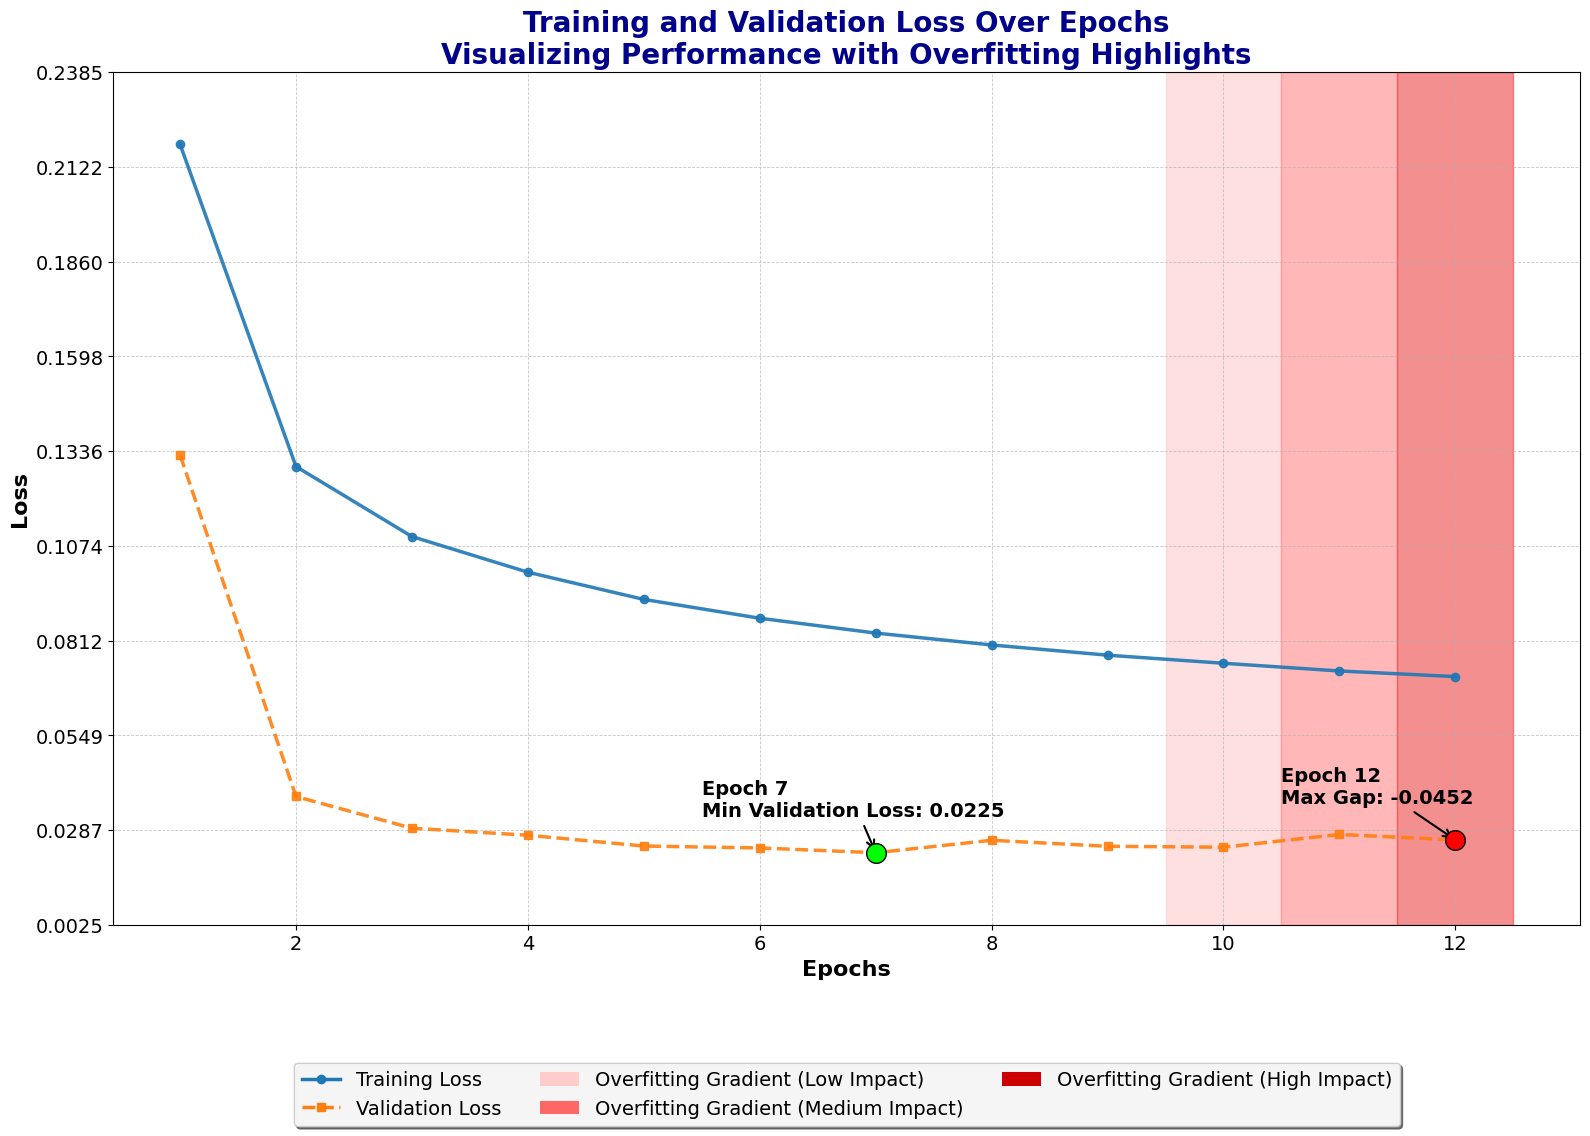

In [29]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Ensure inputs are valid
if len(train_losses) != len(validation_losses):
    raise ValueError("The lengths of train_losses and validation_losses must be equal.")

# Define the number of epochs
epochs = range(1, len(train_losses) + 1)

# Calculate metrics
min_val_loss_epoch = np.argmin(validation_losses) + 1  # 1-based indexing
min_val_loss = validation_losses[min_val_loss_epoch - 1]

# Calculate the epoch with the largest training-validation gap
loss_gap = np.array(validation_losses) - np.array(train_losses)
max_gap_epoch = np.argmax(loss_gap) + 1
max_gap = loss_gap[max_gap_epoch - 1]

# Identify the last three epochs with no improvement in validation loss
no_improvement_epochs = []
for i in range(len(validation_losses) - 3, len(validation_losses)):
    if validation_losses[i] >= min_val_loss:
        no_improvement_epochs.append(i + 1)

# Gradient color map for the overfitting zone
cmap = LinearSegmentedColormap.from_list("OverfittingGradient", ["#ffcccc", "#ff6666", "#cc0000"])

# Plotting
plt.figure(figsize=(16, 10))

# Plot Training Loss
training_line, = plt.plot(epochs, train_losses, label='Training Loss', 
                          marker='o', linestyle='-', linewidth=2.5, color='#1f77b4', alpha=0.9)

# Plot Validation Loss
validation_line, = plt.plot(epochs, validation_losses, label='Validation Loss', 
                            marker='s', linestyle='--', linewidth=2.5, color='#ff7f0e', alpha=0.9)

# Highlight Minimum Validation Loss
plt.scatter(min_val_loss_epoch, min_val_loss, color='lime', edgecolor='black', s=200, zorder=5, 
            label=f"Min Validation Loss (Epoch {min_val_loss_epoch})")
plt.annotate(f"Epoch {min_val_loss_epoch}\nMin Validation Loss: {min_val_loss:.4f}", 
             xy=(min_val_loss_epoch, min_val_loss), 
             xytext=(min_val_loss_epoch - 1.5, min_val_loss + 0.01),  # Adjusted placement
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
             fontsize=14, color='black', fontweight='bold')  # Bold and larger text

# Highlight Maximum Training-Validation Gap
plt.scatter(max_gap_epoch, validation_losses[max_gap_epoch - 1], color='red', edgecolor='black', s=200, zorder=5, 
            label=f"Max Gap (Epoch {max_gap_epoch})")
plt.annotate(f"Epoch {max_gap_epoch}\nMax Gap: {max_gap:.4f}", 
             xy=(max_gap_epoch, validation_losses[max_gap_epoch - 1]), 
             xytext=(max_gap_epoch - 1.5, validation_losses[max_gap_epoch - 1] + 0.01),  # Moved annotation to the left
             arrowprops=dict(facecolor='black', arrowstyle='->', lw=1.5),
             fontsize=14, color='black', fontweight='bold')  # Bold and larger text

# Highlight the Overfitting Zone for the last three epochs with no improvement
for i, epoch in enumerate(no_improvement_epochs):
    plt.axvspan(epoch - 0.5, epoch + 0.5, color=cmap(i / len(no_improvement_epochs)), alpha=0.6, zorder=0)

# Create Line and Gradient Legends
line_legend = [
    Line2D([0], [0], color='#1f77b4', marker='o', linestyle='-', linewidth=2.5, label='Training Loss'),
    Line2D([0], [0], color='#ff7f0e', marker='s', linestyle='--', linewidth=2.5, label='Validation Loss')
]

gradient_legend = [
    Patch(facecolor='#ffcccc', label='Overfitting Gradient (Low Impact)'),
    Patch(facecolor='#ff6666', label='Overfitting Gradient (Medium Impact)'),
    Patch(facecolor='#cc0000', label='Overfitting Gradient (High Impact)')
]

# Combine Legends
main_legend = plt.legend(handles=line_legend + gradient_legend, fontsize=14, loc='upper center', 
                         bbox_to_anchor=(0.5, -0.15), ncol=3, fancybox=True, shadow=True, framealpha=0.9)

plt.gca().add_artist(main_legend)

# Titles and Labels
plt.title('Training and Validation Loss Over Epochs\nVisualizing Performance with Overfitting Highlights', 
          fontsize=20, fontweight='bold', color='darkblue')
plt.xlabel('Epochs', fontsize=16, fontweight='bold')
plt.ylabel('Loss', fontsize=16, fontweight='bold')

# Adjust the Y-axis range dynamically based on the losses
y_min = min(min(train_losses), min(validation_losses)) - 0.02  # Extend grid range below
y_max = max(max(train_losses), max(validation_losses)) + 0.02  # Extend grid range above
plt.ylim(y_min, y_max)

# Add Grid
plt.grid(visible=True, linestyle='--', linewidth=0.6, alpha=0.7)
plt.yticks(np.linspace(y_min, y_max, 10))  # Add more ticks to the y-axis for a detailed grid

# Customize Ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Adjust Layout
plt.tight_layout()

# Show Plot
plt.show()